In [36]:
import os
from urllib.parse import quote

import bs4
from bs4 import BeautifulSoup
import requests

BASE_URL = 'http://www.imsdb.com'
corpus_path = 'C:/Users/Rik/Documents/corpus/'
results_folder = 'imsdb_parsed'
scripts_folder = 'scripts'

In [37]:
def get_script_blocks_from_link(script_url):
    print("Retrieving script on", script_url)
    reading_state = []
    script_soup = BeautifulSoup(requests.get(script_url).text, "html.parser")
    found_blocks = []
    def get_text_recursively(tag, is_bold=False):
        if isinstance(tag, bs4.element.NavigableString) and len(reading_state) > 0:
            text = tag.string
            stripped_text = text.lstrip()
            leading_spaces = len(text) - len(stripped_text)
            is_empty = not stripped_text.strip()
            found_blocks.append({
                'text': stripped_text,
                'leading_spaces': leading_spaces,
                'is_bold': is_bold,
                'is_empty': is_empty
            })
        if isinstance(tag, bs4.element.Tag):
            if tag.name == 'td' and tag.has_attr('class') and tag['class'][0] == 'scrtext':
                reading_state.append(True)
            if tag.name == 'table' and len(reading_state) > 0:
                reading_state.pop()
            if tag.name != 'head' and tag.name != 'script':
                for el in tag:
                    get_text_recursively(el, tag.name == 'b' or is_bold)
    get_text_recursively(script_soup)
    return found_blocks

In [38]:
def get_character_scene_leading_spaces(df_script_blocks):
    df_script_blocks_bold = df_script_blocks[np.logical_and(df_script_blocks['is_bold']==True, df_script_blocks['is_empty']==False)]
    if(len(df_script_blocks_bold)==0):
        return None, None
    count_by_leading = [{'leading_spaces': leading_spaces, 'count': len(bold_group)} for leading_spaces, bold_group in df_script_blocks_bold.groupby(['leading_spaces'])]
    df_count_by_leading = pd.DataFrame(count_by_leading).sort_values('count', ascending=False)
    if(len(df_count_by_leading)> 2):
        return df_count_by_leading.iloc[0]['leading_spaces'], df_count_by_leading.iloc[1]['leading_spaces']
    return None, None

In [39]:
import re

def clean_text(text):
    text = text.replace('\r', ' ').replace('\n', ' ')
    return re.sub(r"\s+", " ", text).strip()

def clean_character(character):
    # check if there's a ( in the character
    if "(" not in character:
        return character, ""
    splitCharacter, splitBracket, splitSuffix = character.rpartition("(")
    return splitCharacter.strip(), (splitBracket + splitSuffix).strip()

In [43]:
import pandas as pd
import numpy as np
def get_script_from_page(script_url):
    try:
        script_blocks = get_script_blocks_from_link(script_url)
    except:
        print("error getting blocks")
        return None
    if (len(script_blocks)==0):
        print("No blocks found")
        return None
    df_script_blocks = pd.DataFrame(script_blocks)
    character_leading_spaces, scene_leading_spaces = get_character_scene_leading_spaces(df_script_blocks)
    if not character_leading_spaces:
        print("Couldn't find correct leading spaces")
        return None
    intro = ""
    scenes = []
    current_scene = None
    characters = []
    current_dialogue = None
    for idx, row in df_script_blocks.iterrows():
        cleaned_text = clean_text(row['text'])
        # if we don't have a scene and the row is not bold we're still in the intro
        if current_scene is None and not row['is_bold'] and cleaned_text != '':
            intro += cleaned_text + " "
        elif row['is_bold']:
            # reset current dialogue if bold
            if current_dialogue is not None and current_scene is not None:
                current_dialogue['text'] = current_dialogue['text'].strip() 
                current_scene['body'].append(current_dialogue)
                current_dialogue = None
            # if it's a bold row it's either a scene, a character, or an empty line
            if row['leading_spaces'] == scene_leading_spaces:
                # store previous scene
                if current_scene is not None:
                    scenes.append(current_scene)
                # create new scene
                current_scene = { 'heading': cleaned_text, 'body': []}
            elif row['leading_spaces'] == character_leading_spaces and current_scene is not None:
                # get character name
                character_name = cleaned_text
                cleaned_character_name, dialogue_suffix = clean_character(character_name)
                # if character in list, add
                if cleaned_character_name not in characters:
                    characters.append(cleaned_character_name)
                # add a dialogue
                current_dialogue = {
                    'type': 'dialogue',
                    'character': cleaned_character_name,
                    'suffix': dialogue_suffix,
                    'text': ''
                }
            elif current_scene is None and cleaned_text != '':
                # if we're still in the intro but it's bold
                intro += cleaned_text + " "
        elif current_scene is not None:
            # empty row might mean a dialogue is done
            if row['is_empty']:
                if current_dialogue is not None and current_scene is not None:
                    current_dialogue['text'] = current_dialogue['text'].strip() 
                    current_scene['body'].append(current_dialogue)
                    current_dialogue = None
            # if we still have a dialogue it's a dialogue
            elif current_dialogue is not None and cleaned_text != '':
                current_dialogue['text'] += cleaned_text + " "
            elif cleaned_text != '':
                current_scene['body'].append({'type': 'action', 'text': cleaned_text})
    # after the loop we want to append the current dialogue to the scene
    if current_dialogue is not None and current_scene is not None:
        current_dialogue['text'] = current_dialogue['text'].strip() 
        current_scene['body'].append(current_dialogue)
        current_dialogue = None
    if current_scene is not None:
        scenes.append(current_scene)
    
    intro = intro.strip()
    return {
        'intro': intro,
        'scenes': scenes,
        'characters': characters
    }

In [44]:
def get_script(anchor):
    title = anchor.text
    print(title)
    relative_link = anchor['href']
    tail = relative_link.split('/')[-1]
    script_front_url = BASE_URL + quote(relative_link)
    front_page_response = requests.get(script_front_url)
    front_soup = BeautifulSoup(front_page_response.text, "html.parser")

    try:
        script_link = front_soup.find_all('p', align="center")[0].a['href']
    except IndexError:
        print('%s has no script :(' % tail)
        return None, None

    if script_link.endswith('.html'):
        file_title = script_link.split('/')[-1].split(' Script')[0].strip('.html')
        script_url = BASE_URL + script_link
        script = get_script_from_page(script_url)
        if script is None:
            return None, None
        script['title'] = title
        script['file_title'] = file_title
        script['script_url'] = script_url
        return file_title, script
    else:
        print('%s is a pdf :(' % tail)
        return None, None

In [45]:
import json

response = requests.get('http://www.imsdb.com/all%20scripts/')
html = response.text

soup = BeautifulSoup(html, "html.parser")
paragraphs = soup.find_all('p')

correct_parsed = []
no_script = []
error = []

for p in paragraphs:
    
    anchor = p.a
    
    title, script = get_script(anchor)
    if not script:
        no_script.append(anchor['href'])
        continue
    try:
        with open(os.path.join(corpus_path, results_folder, scripts_folder, title + '.json'), 'w') as outfile:
            outfile.write(json.dumps(script))
        scene_count = len(script['scenes'])
        empty_scenes = list(filter(lambda s: len(s['body']) == 0, script['scenes']))
        empty_scene_count = len(empty_scenes)
        character_count = len(script['characters'])
        print("Found", scene_count, "scenes (", empty_scene_count," empty) and", character_count, "characters")
        correct_parsed.append({
            'TITLE': script['title'],
            'SCRIPT_URL': script['script_url'],
            'FILE_TITLE': script['file_title'],
            'SCENE_COUNT': scene_count,
            'EMPTY_SCENE_COUNT': empty_scene_count,
            'CHARACTER_COUNT': character_count
        })
    except:
        print("error while writing")
        error.append(anchor['href'])
print("Correctly parsed", len(correct_parsed))
print("No script", len(no_script))
print("Errors", len(error))
for error_url in error:
    print(error_url)

10 Things I Hate About You
Retrieving script on http://www.imsdb.com/scripts/10-Things-I-Hate-About-You.html
Found 141 scenes ( 4  empty) and 34 characters
12
Retrieving script on http://www.imsdb.com/scripts/12.html
Found 311 scenes ( 15  empty) and 53 characters
12 and Holding
Retrieving script on http://www.imsdb.com/scripts/12-and-Holding.html
Found 266 scenes ( 15  empty) and 28 characters
12 Monkeys
Retrieving script on http://www.imsdb.com/scripts/12-Monkeys.html
Found 201 scenes ( 13  empty) and 102 characters
12 Years a Slave
Retrieving script on http://www.imsdb.com/scripts/12-Years-a-Slave.html
Found 228 scenes ( 7  empty) and 103 characters
127 Hours
Retrieving script on http://www.imsdb.com/scripts/127-Hours.html
Found 262 scenes ( 13  empty) and 37 characters
1492: Conquest of Paradise
Retrieving script on http://www.imsdb.com/scripts/1492-Conquest-of-Paradise.html
Found 176 scenes ( 8  empty) and 42 characters
15 Minutes
Retrieving script on http://www.imsdb.com/scripts/

Retrieving script on http://www.imsdb.com/scripts/American-Hustle.html
Found 224 scenes ( 51  empty) and 39 characters
American Madness
Retrieving script on http://www.imsdb.com/scripts/American-Madness.html
Couldn't find correct leading spaces
American Milkshake
Retrieving script on http://www.imsdb.com/scripts/American-Milkshake.html
Found 106 scenes ( 0  empty) and 30 characters
American Outlaws
Retrieving script on http://www.imsdb.com/scripts/American-Outlaws.html
Couldn't find correct leading spaces
American Pie
Retrieving script on http://www.imsdb.com/scripts/American-Pie.html
Found 238 scenes ( 10  empty) and 58 characters
American President, The
Retrieving script on http://www.imsdb.com/scripts/American-President,-The.html
Found 145 scenes ( 14  empty) and 73 characters
American Psycho
Retrieving script on http://www.imsdb.com/scripts/American-Psycho.html
Couldn't find correct leading spaces
American Shaolin: King of Kickboxers II
Retrieving script on http://www.imsdb.com/scr

Found 201 scenes ( 10  empty) and 17 characters
Bad Dreams
Retrieving script on http://www.imsdb.com/scripts/Bad-Dreams.html
Couldn't find correct leading spaces
Bad Lieutenant
Retrieving script on http://www.imsdb.com/scripts/Bad-Lieutenant.html
Found 78 scenes ( 13  empty) and 42 characters
Bad Santa
Retrieving script on http://www.imsdb.com/scripts/Bad-Santa.html
Found 157 scenes ( 14  empty) and 43 characters
Bad Teacher
Retrieving script on http://www.imsdb.com/scripts/Bad-Teacher.html
Found 277 scenes ( 31  empty) and 67 characters
Badlands
Retrieving script on http://www.imsdb.com/scripts/Badlands.html
Couldn't find correct leading spaces
Bamboozled
Retrieving script on http://www.imsdb.com/scripts/Bamboozled.html
Found 451 scenes ( 40  empty) and 79 characters
Barry Lyndon
Retrieving script on http://www.imsdb.com/scripts/Barry-Lyndon.html
Found 245 scenes ( 2  empty) and 63 characters
Barton Fink
Retrieving script on http://www.imsdb.com/scripts/Barton-Fink.html
Found 257 scen

Retrieving script on http://www.imsdb.com/scripts/Body-of-Evidence.html
Found 104 scenes ( 0  empty) and 26 characters
Bodyguard
Retrieving script on http://www.imsdb.com/scripts/Bodyguard.html
Found 255 scenes ( 1  empty) and 17 characters
Bones
Retrieving script on http://www.imsdb.com/scripts/Bones.html
Found 228 scenes ( 2  empty) and 36 characters
Bonfire of the Vanities
Retrieving script on http://www.imsdb.com/scripts/Bonfire-of-the-Vanities.html
Found 442 scenes ( 47  empty) and 54 characters
Bonnie and Clyde
Retrieving script on http://www.imsdb.com/scripts/Bonnie-and-Clyde.html
Found 172 scenes ( 6  empty) and 35 characters
Boogie Nights
Retrieving script on http://www.imsdb.com/scripts/Boogie-Nights.html
Found 431 scenes ( 196  empty) and 8 characters
Book of Eli, The
Retrieving script on http://www.imsdb.com/scripts/Book-of-Eli,-The.html
Found 121 scenes ( 0  empty) and 34 characters
Boondock Saints 2: All Saints Day
Retrieving script on http://www.imsdb.com/scripts/Boondoc

Retrieving script on http://www.imsdb.com/scripts/Chronicle.html
Found 110 scenes ( 10  empty) and 36 characters
Chronicles of Narnia: The Lion, the Witch and the Wardrobe
Retrieving script on http://www.imsdb.com/scripts/Chronicles-of-Narnia-The-Lion,-the-Witch-and-the-Wardrobe.html
Found 49 scenes ( 4  empty) and 48 characters
Cider House Rules, The
Retrieving script on http://www.imsdb.com/scripts/Cider-House-Rules,-The.html
Found 193 scenes ( 3  empty) and 40 characters
Cincinnati Kid, The
Retrieving script on http://www.imsdb.com/scripts/Cincinnati-Kid,-The.html
Found 233 scenes ( 34  empty) and 43 characters
Cinema Paradiso
Retrieving script on http://www.imsdb.com/scripts/Cinema-Paradiso.html
Found 131 scenes ( 2  empty) and 76 characters
Cirque du Freak: The Vampire's Assistant
Retrieving script on http://www.imsdb.com/scripts/Cirque-du-Freak-The-Vampire's-Assistant.html
Found 300 scenes ( 24  empty) and 77 characters
Citizen Kane
Retrieving script on http://www.imsdb.com/scrip

Retrieving script on http://www.imsdb.com/scripts/Day-the-Earth-Stood-Still,-The.html
Found 367 scenes ( 13  empty) and 56 characters
Days of Heaven
Retrieving script on http://www.imsdb.com/scripts/Days-of-Heaven.html
Couldn't find correct leading spaces
Dead Poets Society
Retrieving script on http://www.imsdb.com/scripts/Dead-Poets-Society.html
Found 106 scenes ( 0  empty) and 52 characters
Deadpool
Retrieving script on http://www.imsdb.com/scripts/Deadpool.html
Found 209 scenes ( 3  empty) and 25 characters
Dear White People
Retrieving script on http://www.imsdb.com/scripts/Dear-White-People.html
Found 325 scenes ( 1  empty) and 25 characters
Death at a Funeral
Retrieving script on http://www.imsdb.com/scripts/Death-at-a-Funeral.html
Found 316 scenes ( 14  empty) and 42 characters
Death to Smoochy
Retrieving script on http://www.imsdb.com/scripts/Death-to-Smoochy.html
Found 343 scenes ( 47  empty) and 37 characters
Debt, The
Retrieving script on http://www.imsdb.com/scripts/Debt,-Th

Retrieving script on http://www.imsdb.com/scripts/Event-Horizon.html
Found 375 scenes ( 34  empty) and 16 characters
Evil Dead
Retrieving script on http://www.imsdb.com/scripts/Evil-Dead.html
Couldn't find correct leading spaces
Evil Dead II: Dead by Dawn
Retrieving script on http://www.imsdb.com/scripts/Evil-Dead-II-Dead-by-Dawn.html
Couldn't find correct leading spaces
Ex Machina
Retrieving script on http://www.imsdb.com/scripts/Ex-Machina.html
Found 166 scenes ( 18  empty) and 5 characters
Excalibur
Retrieving script on http://www.imsdb.com/scripts/Excalibur.html
Found 185 scenes ( 6  empty) and 35 characters
Executive Decision
Executive Decision Script.html has no script :(
eXistenZ
Retrieving script on http://www.imsdb.com/scripts/eXistenZ.html
Found 56 scenes ( 0  empty) and 71 characters
Extract
Retrieving script on http://www.imsdb.com/scripts/Extract.html
Found 220 scenes ( 18  empty) and 55 characters
Eyes Wide Shut
Eyes Wide Shut Script.html has no script :(
Fabulous Baker B

Retrieving script on http://www.imsdb.com/scripts/Gandhi.html
Found 188 scenes ( 10  empty) and 136 characters
Gang Related
Retrieving script on http://www.imsdb.com/scripts/Gang-Related.html
Found 198 scenes ( 3  empty) and 66 characters
Gangs of New York
Retrieving script on http://www.imsdb.com/scripts/Gangs-of-New-York.html
Couldn't find correct leading spaces
Garden State
Retrieving script on http://www.imsdb.com/scripts/Garden-State.html
Found 153 scenes ( 16  empty) and 213 characters
Gattaca
Retrieving script on http://www.imsdb.com/scripts/Gattaca.html
Found 182 scenes ( 9  empty) and 40 characters
Get Carter
Retrieving script on http://www.imsdb.com/scripts/Get-Carter.html
Found 152 scenes ( 4  empty) and 32 characters
Get Low
Retrieving script on http://www.imsdb.com/scripts/Get-Low.html
Found 251 scenes ( 21  empty) and 54 characters
Get on Up
Retrieving script on http://www.imsdb.com/scripts/Get-on-Up.html
Found 226 scenes ( 2  empty) and 38 characters
Get Out
Retrieving s

Found 233 scenes ( 0  empty) and 52 characters
Harry Potter and the Chamber of Secrets
Harry Potter and the Chamber of Secrets Script.html has no script :(
Harry Potter and the Deathly Hallows Part 1
Harry Potter and the Deathly Hallows Part 1 Script.html has no script :(
Harry Potter and the Goblet of Fire
Harry Potter and the Goblet of Fire Script.html has no script :(
Harry Potter and the Half-Blood Prince
Harry Potter and the Half-Blood Prince Script.html has no script :(
Harry Potter and the Prisoner of Azkaban
Harry Potter and the Prisoner of Azkaban Script.html has no script :(
Harry Potter and the Sorcerer's Stone
Harry Potter and the Sorcerer's Stone Script.html has no script :(
Haunting, The
Retrieving script on http://www.imsdb.com/scripts/Haunting,-The.html
Found 196 scenes ( 5  empty) and 19 characters
He's Just Not That Into You
Retrieving script on http://www.imsdb.com/scripts/He's-Just-Not-That-Into-You.html
Found 238 scenes ( 16  empty) and 56 characters
Heat
Retrievin

Retrieving script on http://www.imsdb.com/scripts/In-the-Loop.html
Found 289 scenes ( 0  empty) and 28 characters
Inception
Retrieving script on http://www.imsdb.com/scripts/Inception.html
Found 328 scenes ( 20  empty) and 23 characters
Incredibles, The
Retrieving script on http://www.imsdb.com/scripts/Incredibles,-The.html
Couldn't find correct leading spaces
Independence Day
Retrieving script on http://www.imsdb.com/scripts/Independence-Day.html
Found 406 scenes ( 16  empty) and 103 characters
Indiana Jones and the Last Crusade
Retrieving script on http://www.imsdb.com/scripts/Indiana-Jones-and-the-Last-Crusade.html
Found 344 scenes ( 1  empty) and 21 characters
Indiana Jones and the Raiders of the Lost Ark
Retrieving script on http://www.imsdb.com/scripts/Indiana-Jones-and-the-Raiders-of-the-Lost-Ark.html
Found 174 scenes ( 4  empty) and 31 characters
Indiana Jones and the Temple of Doom
Retrieving script on http://www.imsdb.com/scripts/Indiana-Jones-and-the-Temple-of-Doom.html
Foun

Retrieving script on http://www.imsdb.com/scripts/Kingdom,-The.html
Found 234 scenes ( 1  empty) and 40 characters
Kiss of the Spider Woman
Kiss of the Spider Woman Script.html is a pdf :(
Klute
Retrieving script on http://www.imsdb.com/scripts/Klute.html
Found 253 scenes ( 27  empty) and 50 characters
Knocked Up
Retrieving script on http://www.imsdb.com/scripts/Knocked-Up.html
Found 212 scenes ( 3  empty) and 47 characters
Kramer vs Kramer
Retrieving script on http://www.imsdb.com/scripts/Kramer-vs-Kramer.html
Found 487 scenes ( 124  empty) and 38 characters
Kundun
Retrieving script on http://www.imsdb.com/scripts/Kundun.html
Found 224 scenes ( 4  empty) and 66 characters
Kung Fu Panda
Retrieving script on http://www.imsdb.com/scripts/Kung-Fu-Panda.html
Found 71 scenes ( 1  empty) and 33 characters
L.A. Confidential
Retrieving script on http://www.imsdb.com/scripts/L.A.-Confidential.html
Found 247 scenes ( 6  empty) and 64 characters
La La Land
Retrieving script on http://www.imsdb.co

Retrieving script on http://www.imsdb.com/scripts/Lost-in-Translation.html
Found 146 scenes ( 22  empty) and 36 characters
Love and Basketball
Retrieving script on http://www.imsdb.com/scripts/Love-and-Basketball.html
Found 122 scenes ( 11  empty) and 52 characters
Machete
Retrieving script on http://www.imsdb.com/scripts/Machete.html
Found 179 scenes ( 8  empty) and 53 characters
Machine Gun Preacher
Retrieving script on http://www.imsdb.com/scripts/Machine-Gun-Preacher.html
Found 310 scenes ( 15  empty) and 179 characters
Mad Max 2: The Road Warrior
Retrieving script on http://www.imsdb.com/scripts/Mad-Max-2-The-Road-Warrior.html
Found 203 scenes ( 14  empty) and 216 characters
Made
Retrieving script on http://www.imsdb.com/scripts/Made.html
Couldn't find correct leading spaces
Magnolia
Retrieving script on http://www.imsdb.com/scripts/Magnolia.html
Found 288 scenes ( 0  empty) and 102 characters
Majestic, The (The Bijou)
Retrieving script on http://www.imsdb.com/scripts/Majestic,-Th

Found 467 scenes ( 19  empty) and 24 characters
Moneyball
Retrieving script on http://www.imsdb.com/scripts/Moneyball.html
Found 478 scenes ( 176  empty) and 141 characters
Monkeybone
Retrieving script on http://www.imsdb.com/scripts/Monkeybone.html
Found 180 scenes ( 4  empty) and 77 characters
Monster's Ball
Monster's Ball Script.html is a pdf :(
Monte Carlo
Retrieving script on http://www.imsdb.com/scripts/Monte-Carlo.html
Found 165 scenes ( 2  empty) and 108 characters
Moon
Retrieving script on http://www.imsdb.com/scripts/Moon.html
Couldn't find correct leading spaces
Moonrise Kingdom
Retrieving script on http://www.imsdb.com/scripts/Moonrise-Kingdom.html
Found 342 scenes ( 19  empty) and 36 characters
Moonstruck
Retrieving script on http://www.imsdb.com/scripts/Moonstruck.html
Found 224 scenes ( 24  empty) and 54 characters
Mr Blandings Builds His Dream House
Retrieving script on http://www.imsdb.com/scripts/Mr-Blandings-Builds-His-Dream-House.html
Found 167 scenes ( 12  empty) a

Retrieving script on http://www.imsdb.com/scripts/Orgy-of-the-Dead.html
Found 39 scenes ( 6  empty) and 10 characters
Orphan
Retrieving script on http://www.imsdb.com/scripts/Orphan.html
Found 502 scenes ( 355  empty) and 510 characters
Other Boleyn Girl, The
Retrieving script on http://www.imsdb.com/scripts/Other-Boleyn-Girl,-The.html
Found 267 scenes ( 20  empty) and 29 characters
Out of Sight
Retrieving script on http://www.imsdb.com/scripts/Out-of-Sight.html
Found 212 scenes ( 4  empty) and 50 characters
Outbreak
Outbreak Script.html has no script :(
Pacifier, The
Retrieving script on http://www.imsdb.com/scripts/Pacifier,-The.html
Found 265 scenes ( 18  empty) and 57 characters
Pandorum
Retrieving script on http://www.imsdb.com/scripts/Pandorum.html
Found 398 scenes ( 40  empty) and 88 characters
Panic Room
Retrieving script on http://www.imsdb.com/scripts/Panic-Room.html
Found 293 scenes ( 12  empty) and 13 characters
Papadopoulos & Sons
Retrieving script on http://www.imsdb.com/

Retrieving script on http://www.imsdb.com/scripts/Queen,-The.html
Found 175 scenes ( 6  empty) and 51 characters
Rachel Getting Married
Retrieving script on http://www.imsdb.com/scripts/Rachel-Getting-Married.html
Found 180 scenes ( 8  empty) and 30 characters
Raging Bull
Retrieving script on http://www.imsdb.com/scripts/Raging-Bull.html
Found 244 scenes ( 0  empty) and 41 characters
Raising Arizona
Retrieving script on http://www.imsdb.com/scripts/Raising-Arizona.html
Found 370 scenes ( 3  empty) and 40 characters
Rambling Rose
Retrieving script on http://www.imsdb.com/scripts/Rambling-Rose.html
Found 237 scenes ( 7  empty) and 22 characters
Rambo: First Blood II: The Mission
Retrieving script on http://www.imsdb.com/scripts/Rambo-First-Blood-II-The-Mission.html
Found 346 scenes ( 13  empty) and 33 characters
Reader, The
Retrieving script on http://www.imsdb.com/scripts/Reader,-The.html
Found 201 scenes ( 2  empty) and 34 characters
Real Genius
Retrieving script on http://www.imsdb.co

Retrieving script on http://www.imsdb.com/scripts/Semi-Pro.html
Found 502 scenes ( 368  empty) and 551 characters
Sense and Sensibility
Retrieving script on http://www.imsdb.com/scripts/Sense-and-Sensibility.html
Found 201 scenes ( 1  empty) and 28 characters
Serenity
Retrieving script on http://www.imsdb.com/scripts/Serenity.html
Found 528 scenes ( 376  empty) and 343 characters
Serial Mom
Retrieving script on http://www.imsdb.com/scripts/Serial-Mom.html
Found 161 scenes ( 0  empty) and 76 characters
Sessions, The
Retrieving script on http://www.imsdb.com/scripts/Sessions,-The.html
Found 195 scenes ( 0  empty) and 26 characters
Seventh Seal, The
Retrieving script on http://www.imsdb.com/scripts/Seventh-Seal,-The.html
Found 4 scenes ( 0  empty) and 14 characters
Sex and the City
Retrieving script on http://www.imsdb.com/scripts/Sex-and-the-City.html
Found 379 scenes ( 0  empty) and 38 characters
Sex, Lies and Videotape
Retrieving script on http://www.imsdb.com/scripts/Sex,-Lies-and-Vid

Couldn't find correct leading spaces
Star Trek: First Contact
Retrieving script on http://www.imsdb.com/scripts/Star-Trek-First-Contact.html
Couldn't find correct leading spaces
Star Trek: Generations
Retrieving script on http://www.imsdb.com/scripts/Star-Trek-Generations.html
Couldn't find correct leading spaces
Star Trek: Nemesis
Retrieving script on http://www.imsdb.com/scripts/Star-Trek-Nemesis.html
Found 149 scenes ( 1  empty) and 28 characters
Star Trek: The Motion Picture
Retrieving script on http://www.imsdb.com/scripts/Star-Trek-The-Motion-Picture.html
Found 242 scenes ( 23  empty) and 46 characters
Star Wars: A New Hope
Retrieving script on http://www.imsdb.com/scripts/Star-Wars-A-New-Hope.html
Found 489 scenes ( 6  empty) and 67 characters
Star Wars: Attack of the Clones
Retrieving script on http://www.imsdb.com/scripts/Star-Wars-Attack-of-the-Clones.html
Couldn't find correct leading spaces
Star Wars: Return of the Jedi
Retrieving script on http://www.imsdb.com/scripts/Star

Retrieving script on http://www.imsdb.com/scripts/Thirteen-Days.html
Found 319 scenes ( 28  empty) and 67 characters
This Boy's Life
Retrieving script on http://www.imsdb.com/scripts/This-Boy's-Life.html
Found 270 scenes ( 3  empty) and 25 characters
This is 40
Retrieving script on http://www.imsdb.com/scripts/This-is-40.html
Found 234 scenes ( 0  empty) and 49 characters
Thor
Retrieving script on http://www.imsdb.com/scripts/Thor.html
Found 392 scenes ( 14  empty) and 68 characters
Thor Ragnarok
Retrieving script on http://www.imsdb.com/scripts/Thor-Ragnarok.html
Found 187 scenes ( 49  empty) and 25 characters
Three Kings
Retrieving script on http://www.imsdb.com/scripts/Three-Kings.html
Found 209 scenes ( 3  empty) and 54 characters
Three Kings (Spoils of War)
Retrieving script on http://www.imsdb.com/scripts/Three-Kings-(Spoils-of-War).html
Found 82 scenes ( 14  empty) and 16 characters
Three Men and a Baby
Retrieving script on http://www.imsdb.com/scripts/Three-Men-and-a-Baby.html


Retrieving script on http://www.imsdb.com/scripts/Walking-Tall.html
Found 63 scenes ( 1  empty) and 41 characters
Wall Street
Retrieving script on http://www.imsdb.com/scripts/Wall-Street.html
Found 183 scenes ( 11  empty) and 63 characters
Wall Street: Money Never Sleeps
Retrieving script on http://www.imsdb.com/scripts/Wall-Street-Money-Never-Sleeps.html
Found 347 scenes ( 24  empty) and 49 characters
Wall-E
Retrieving script on http://www.imsdb.com/scripts/Wall-E.html
Found 195 scenes ( 1  empty) and 182 characters
Wanted
Retrieving script on http://www.imsdb.com/scripts/Wanted.html
Found 438 scenes ( 325  empty) and 348 characters
War for the Planet of the Apes
Retrieving script on http://www.imsdb.com/scripts/War-for-the-Planet-of-the-Apes.html
Couldn't find correct leading spaces
War Horse
Retrieving script on http://www.imsdb.com/scripts/War-Horse.html
Found 184 scenes ( 8  empty) and 78 characters
War of the Worlds
Retrieving script on http://www.imsdb.com/scripts/War-of-the-Wo

In [46]:
df_films = pd.DataFrame(correct_parsed)
df_films.to_csv(os.path.join(corpus_path, results_folder, 'parse_summary.csv'))

In [47]:
df_films.head()

,CHARACTER_COUNT,EMPTY_SCENE_COUNT,FILE_TITLE,SCENE_COUNT,SCRIPT_URL,TITLE
0,34,4,10-Things-I-Hate-About-You,141,http://www.imsdb.com/scripts/10-Things-I-Hate-...,10 Things I Hate About You
1,53,15,12,311,http://www.imsdb.com/scripts/12.html,12
2,28,15,12-and-Holding,266,http://www.imsdb.com/scripts/12-and-Holding.html,12 and Holding
3,102,13,12-Monkeys,201,http://www.imsdb.com/scripts/12-Monkeys.html,12 Monkeys
4,103,7,12-Years-a-Slave,228,http://www.imsdb.com/scripts/12-Years-a-Slave....,12 Years a Slave


In [48]:
df_films['EMPTY_RATIO'] = df_films['EMPTY_SCENE_COUNT'] / df_films['SCENE_COUNT']

In [49]:
df_films.head()

,CHARACTER_COUNT,EMPTY_SCENE_COUNT,FILE_TITLE,SCENE_COUNT,SCRIPT_URL,TITLE,EMPTY_RATIO
0,34,4,10-Things-I-Hate-About-You,141,http://www.imsdb.com/scripts/10-Things-I-Hate-...,10 Things I Hate About You,0.028369
1,53,15,12,311,http://www.imsdb.com/scripts/12.html,12,0.048232
2,28,15,12-and-Holding,266,http://www.imsdb.com/scripts/12-and-Holding.html,12 and Holding,0.056391
3,102,13,12-Monkeys,201,http://www.imsdb.com/scripts/12-Monkeys.html,12 Monkeys,0.064677
4,103,7,12-Years-a-Slave,228,http://www.imsdb.com/scripts/12-Years-a-Slave....,12 Years a Slave,0.030702


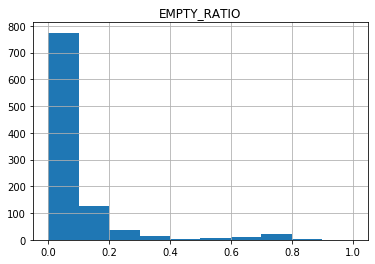

In [50]:
import matplotlib.pyplot as plt
df_films.hist(['EMPTY_RATIO'])
plt.show()